In [1]:
from warnings import filterwarnings
filterwarnings('ignore')

import os
import pickle

import pandas as pd
import numpy as np

import hyperopt

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_curve, roc_auc_score, auc

from catboost import Pool

from AutoML import TrainLog, TrainCat

In [2]:
global SEED

SEED = 12
np.random.seed(SEED)

# Загрузим наши данные

In [3]:
main_path = '/home/roman/Документы/AmazonRecomendationSystem'
save_path = 'fitted_models/'

assert os.path.exists(save_path)

In [4]:
data = pd.read_csv(os.path.join(main_path, 'data/processed/tonality_embeded_dataset.csv')).drop(['Unnamed: 0'], axis=1)

In [5]:
data.head()

,embeded_feature_0,embeded_feature_1,embeded_feature_2,embeded_feature_3,embeded_feature_4,embeded_feature_5,embeded_feature_6,embeded_feature_7,embeded_feature_8,embeded_feature_9,...,embeded_feature_759,embeded_feature_760,embeded_feature_761,embeded_feature_762,embeded_feature_763,embeded_feature_764,embeded_feature_765,embeded_feature_766,embeded_feature_767,target
0,-0.215934,-0.140289,0.008311,-0.101173,-0.098799,-0.092581,0.187413,0.308779,-0.079129,-0.144936,...,-0.291156,-0.136476,-0.077851,0.071078,0.063628,0.084097,-0.136949,0.586700,0.201127,1
1,-0.172627,-0.144762,0.002234,0.030628,0.120575,-0.088869,0.206804,0.255742,-0.114185,-0.007489,...,-0.115842,0.114645,0.047418,0.185320,-0.116279,-0.066597,-0.174425,0.213865,0.371975,0
2,-0.050633,0.072039,-0.029597,-0.140354,-0.080607,-0.103232,0.426805,0.245678,0.046981,-0.148649,...,-0.249636,-0.037668,-0.227981,-0.072469,0.078502,-0.011736,-0.071489,0.718524,0.262255,0
3,-0.147498,0.064452,-0.003698,-0.219294,0.060844,-0.064445,0.004213,0.256716,-0.175174,-0.163916,...,-0.013068,-0.029533,-0.143953,-0.053300,-0.050167,0.021765,-0.078147,0.423837,0.231882,1
4,-0.065416,0.063764,0.027590,-0.120538,-0.069055,-0.089219,0.151275,0.308792,-0.281770,0.076271,...,-0.263472,0.030695,-0.024583,0.068632,0.141143,-0.075043,-0.022626,0.479300,0.391161,1


# Подготовим выборки для моделирования

In [6]:
def split_indexes(
    indexes,
    test_size=0.2,
    val_size=0.2,
    stratify=None,
):
    # сами сформируем разметки для выборок
    np.random.seed(SEED)
    train_size = 1 - test_size - val_size
    assert np.round(train_size + test_size + val_size, 1) == 1.0    
    n_samples = len(indexes)

    if stratify is not None:
        stratify = np.array(stratify)
        classes, counts = np.unique(stratify, return_counts=True)
        train_idx, val_idx, test_idx = [], [], []

        for cls, count in zip(classes, counts):
            # индексы текущего класса
            cls_idx = np.where(stratify == cls)[0]

            # случайно разбиваем их на train/val/test
            np.random.shuffle(cls_idx)
            n_val = int(count * val_size)
            n_test = int(count * test_size)

            val_idx.extend(cls_idx[:n_val])
            test_idx.extend(cls_idx[n_val : n_val + n_test])
            train_idx.extend(cls_idx[n_val + n_test :])

    else:
        idx = np.arange(n_samples)
        np.random.shuffle(idx)

        n_val = int(n_samples * val_size)
        n_test = int(n_samples * test_size)

        val_idx = idx[:n_val]
        test_idx = idx[n_val : n_val + n_test]
        train_idx = idx[n_val + n_test :]

    return train_idx, test_idx, val_idx

In [7]:
train_idx, test_idx, val_idx = split_indexes(
    np.array(data.index),
    test_size=0.3,
    val_size=0.1,
    stratify=data['target']
)

In [8]:
sample = []

for i in data.index:
    if i in train_idx: sample.append('TRAIN')
    elif i in test_idx: sample.append('TEST')
    else: sample.append('VAL')

In [9]:
assert len(train_idx) + len(test_idx) + len(val_idx) == len(sample)

In [10]:
data = pd.concat([
    data,
    pd.DataFrame(sample, columns=['Sample'])
], axis=1)

In [11]:
train = data[data['Sample'] == 'TRAIN']
test = data[data['Sample'] == 'TEST']
val = data[data['Sample'] == 'VAL']

# Построим модели

## Логистическая регрессия

100%|████████| 10/10 [11:24<00:00, 68.48s/trial, best loss: -0.9203277881440031]
CPU times: user 12min 7s, sys: 12.2 s, total: 12min 19s
Wall time: 11min 50s


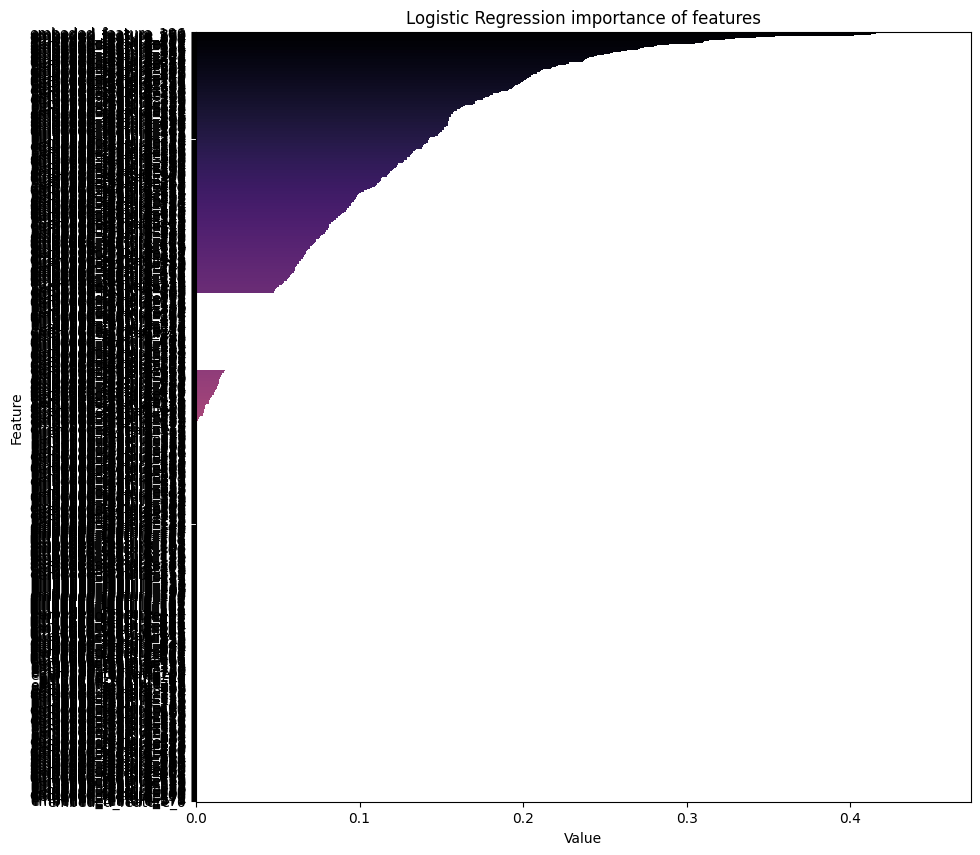

In [12]:
%%time

custom_logreg_params = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': (0.001, 10),
    'solver': ['lbfgs', 'liblinear', 'saga'],
    'max_iter': (100, 1000),
    'l1_ratio': (0, 1),
}

logistic_regression = TrainLog.TrainLogisticRegressionModel(
    x_train=train.drop(['target', 'Sample'], axis=1), y_train=train['target'],
    x_test=test.drop(['target', 'Sample'], axis=1), y_test=test['target'],
    random_seed=SEED,
    params_dict=custom_logreg_params
)

best_logreg, cv_score_logreg, test_score_logreg = logistic_regression.train()

In [48]:
with open(os.path.join(save_path, 'logreg_tonality(AutoML).pkl'), 'wb') as f:
    pickle.dump(best_logreg, f)

## CatBoost

100%|████████| 10/10 [04:50<00:00, 29.08s/trial, best loss: -0.9111518342430396]
CPU times: user 19min 3s, sys: 21.5 s, total: 19min 24s
Wall time: 5min 11s


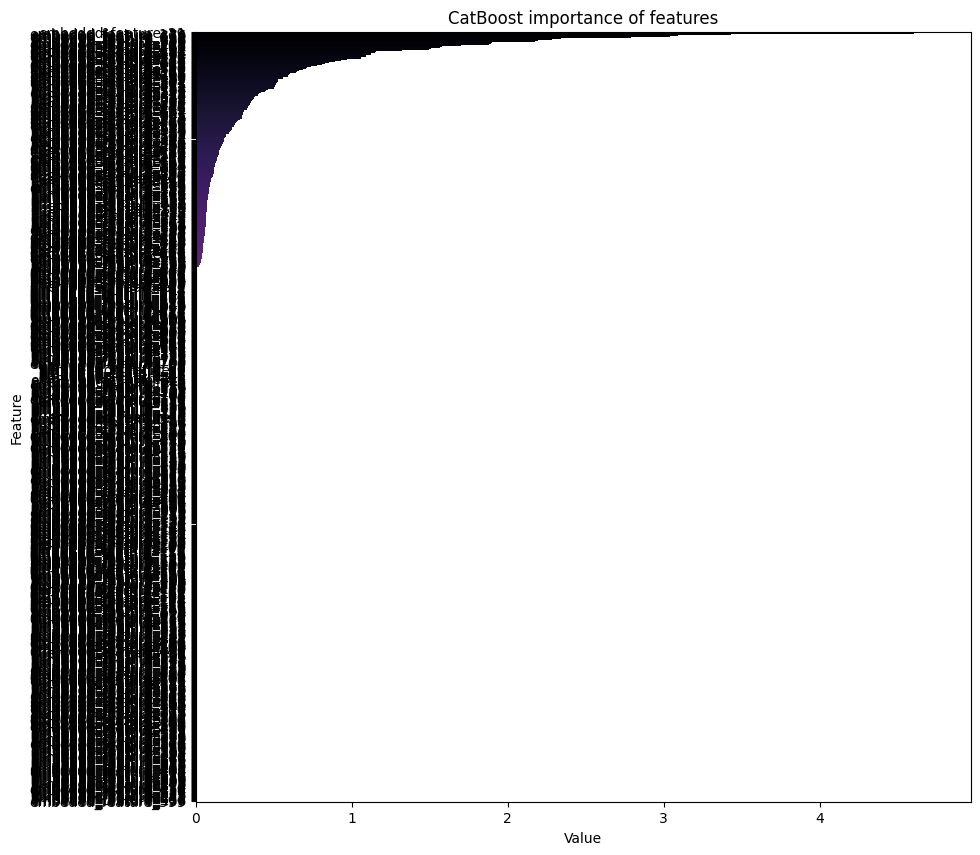

In [14]:
%%time

custom_catboost_params = {
    'boosting_type':  ['Ordered', 'Plain'],
    'iterations': (100, 1000),
    'learning_rate': (0.01, 0.9),
    'depth': (1, 2, 1),
    'l2_leaf_reg': (1e-8, 10),
    'min_data_in_leaf': (30, 250, 10)
}

boosting = TrainCat.TrainCatBoostModel(
    x_train=train.drop(['target', 'Sample'], axis=1), y_train=train['target'],
    x_test=test.drop(['target', 'Sample'], axis=1), y_test=test['target'],
    random_seed=SEED,
    params_dict=custom_catboost_params
)

best_boosting, cv_score_boosting, test_score_boosting = boosting.train()

In [47]:
with open(os.path.join(save_path, 'catboost_tonality(AutoML).pkl'), 'wb') as f:
    pickle.dump(best_boosting, f)

# Результат

In [16]:
tuned_res = pd.DataFrame(
    [
        [cv_score_logreg, test_score_logreg],
        [cv_score_boosting, test_score_boosting]
    ],
    columns=['Cross-Val', 'Test'],
    index=['LogReg Tuned', 'Boost Tuned']
)

tuned_res

,Cross-Val,Test
LogReg Tuned,0.920328,0.912255
Boost Tuned,0.911152,0.899136


In [31]:
logreg_train_pred = roc_auc_score(best_logreg.predict(train.drop(['target', 'Sample'], axis=1)), train['target'])
logreg_test_pred = roc_auc_score(best_logreg.predict(test.drop(['target', 'Sample'], axis=1)), test['target'])
logreg_val_pred = roc_auc_score(best_logreg.predict(val.drop(['target', 'Sample'], axis=1)), val['target'])


train_pool = Pool(train.drop(['target', 'Sample'], axis=1), train['target'])
test_pool = Pool(test.drop(['target', 'Sample'], axis=1), test['target'])
val_pool = Pool(val.drop(['target', 'Sample'], axis=1), val['target'])

catboost_train_pred = roc_auc_score(best_boosting.predict(train_pool), train['target'])
catboost_test_pred = roc_auc_score(best_boosting.predict(test_pool), test['target'])
catboost_val_pred = roc_auc_score(best_boosting.predict(val_pool), val['target'])

res_pred = pd.DataFrame([
    [logreg_train_pred, logreg_test_pred, logreg_val_pred],
    [catboost_train_pred, catboost_test_pred, catboost_val_pred]],
    columns=['Train AUC', 'Test AUC', 'Val AUC'],
    index=['Logistic Regression(Scikit-Learn)', 'Gradient Boosting(Catboost)']
)

In [32]:
res_pred

,Train AUC,Test AUC,Val AUC
Logistic Regression(Scikit-Learn),0.761721,0.760964,0.761974
Gradient Boosting(Catboost),0.901055,0.813250,0.813720


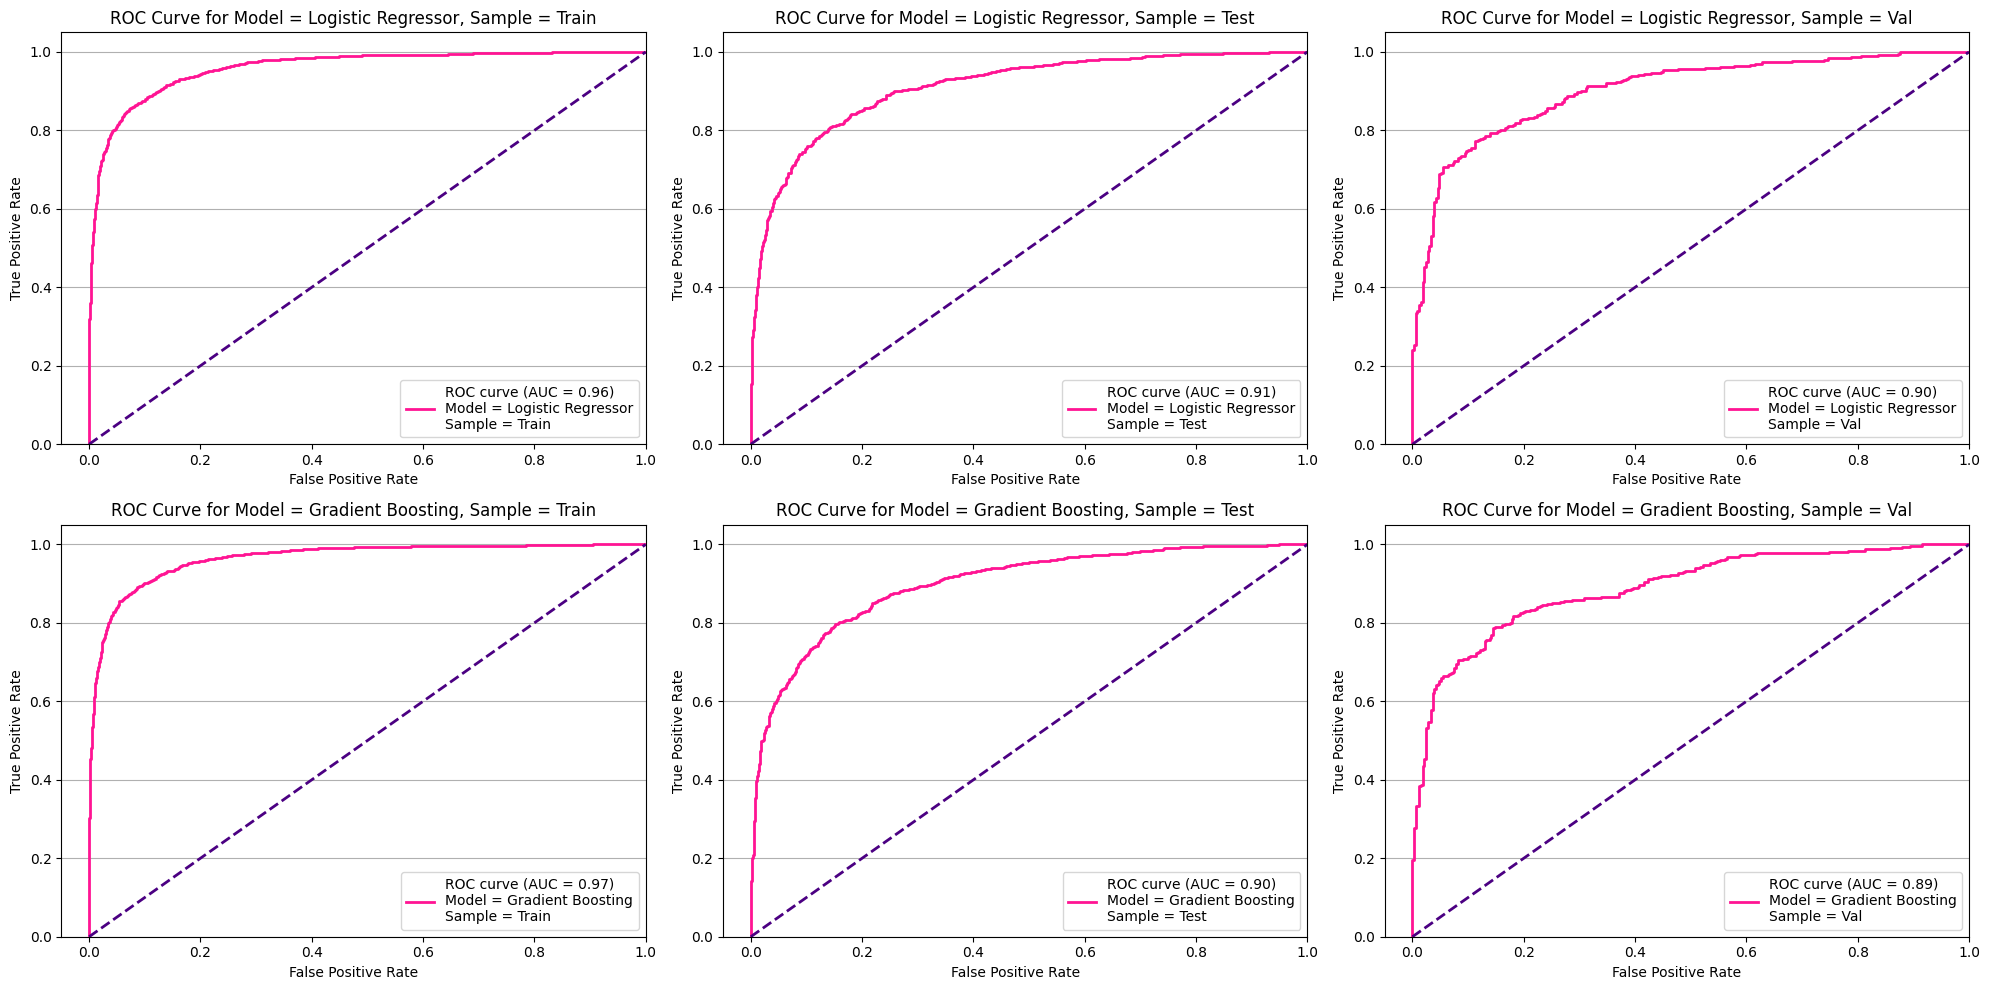

In [33]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))
ax = ax.ravel()  # преобразуем в плоский массив для удобства

models = [
    (best_logreg, 'TRAIN', (train.drop(['target', 'Sample'], axis=1), train['target']), ('Logistic Regressor', 'Train')),
    (best_logreg, 'TEST', (test.drop(['target', 'Sample'], axis=1), test['target']), ('Logistic Regressor', 'Test')),
    (best_logreg, 'VAL', (val.drop(['target', 'Sample'], axis=1), val['target']), ('Logistic Regressor', 'Val')),
    (best_boosting, 'TRAIN', (train_pool, train['target']), ('Gradient Boosting', 'Train')),
    (best_boosting, 'TEST', (test_pool, test['target']), ('Gradient Boosting', 'Test')),
    (best_boosting, 'VAL', (val_pool, val['target']), ('Gradient Boosting', 'Val')),
]

for model, ax_i in zip(models, ax):
    
    y_score = model[0].predict_proba(model[2][0])[:, 1]
    
    fpr, tpr, _ = roc_curve(model[2][1], y_score)
    roc_auc = auc(fpr, tpr)
    
    ax_i.plot(fpr, tpr, color='deeppink', lw=2,
             label=f'ROC curve (AUC = {roc_auc:.2f})\nModel = {model[3][0]}\nSample = {model[3][1]}')
    
    ax_i.plot([0, 1], [0, 1], color='indigo', lw=2, linestyle='--')
    ax_i.set_xlim([-0.05, 1.0])
    ax_i.set_ylim([0.0, 1.05])
    ax_i.set_xlabel('False Positive Rate')
    ax_i.set_ylabel('True Positive Rate')
    ax_i.set_title(f'ROC Curve for Model = {model[3][0]}, Sample = {model[3][1]}')
    ax_i.legend(loc='lower right')
    ax_i.grid(True, axis='y')

plt.tight_layout()
plt.show()

# Предскажем тональность для датасета с отзывами

In [53]:
data = pd.read_csv(os.path.join(main_path, 'data/processed/reviews_embeded_dataset.csv')).drop(['Unnamed: 0', 'target'], axis=1)

model = pickle.load(
    open(os.path.join(save_path, 'catboost_tonality(AutoML).pkl'), 'rb')
)

tonality = model.predict(data)
data = pd.concat([
    data, pd.DataFrame(tonality, columns=['tonality'])
], axis=1)

data.to_csv(os.path.join(main_path, 'data/processed/reviews_tonality_dataset.csv'))